In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import os
import pickle5 as pickle
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

#### The hatespeech data can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). Features are extracted from each tweet using [fasttext](https://pypi.org/project/fasttext/). Data is preprocessed in "preprocess_text_data.py" and saved in "hatespeech_data.pkl". Refer to section 6 of the paper for a detailed description of preprocessing and human predictions modeling. In this notebook we only load the data which we previously generated using the "preprocess_text_data.py".

In [4]:
constraints = [0.2,0.4,0.6,0.8]
data_path = 'hatespeech_data'
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#### The CNN architecture that we used for text classification is that of [Kim 2014](https://arxiv.org/abs/1408.5882).

In [5]:
class CNN(nn.Module):
    def __init__(self, vocab_size, n_filters, filter_sizes, output_dim,
                 dropout):
        super().__init__()
        self.conv_0 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[0]))

        self.conv_1 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[1]))

        self.conv_2 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[2]))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, text):

        embedded = text.unsqueeze(1)

        conved_0 = F.relu(self.conv_0(embedded).squeeze(2))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(2))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(2))


        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        cat = self.fc(cat)
        cat = self.logsoftmax(cat).squeeze()
        return cat

#### The CNN architecture for the [surrogate-based triage](https://arxiv.org/abs/2006.01862)

In [6]:
class CNN_rej(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
        self.convs_rej = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc_rej = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        self.dropout_rej = nn.Dropout(dropout)
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedded):
        
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs]
            
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        embedded_rej = embedded.unsqueeze(1)
                
        conved_rej = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs_rej]
                            
        pooled_rej = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat_rej = self.dropout_rej(torch.cat(pooled, dim = 1))

        out_rej = self.fc_rej(cat_rej)
        
        out = self.fc(cat)
        out =  torch.cat((out, out_rej), 1)

        out = self.softmax(out)
        return out

# Our Method : [Learning Under Triage](https://arxiv.org/abs/2103.08902)

#### According to the optimal triage policy, we need to outsource the samples for which the difference between machine loss and human loss is greater than the threshold $t_{P,b,m}$ (refer to equation 3 in the paper). This is equivalent to sorting the samples based on the difference of machine loss and human loss and then outsourcing the top b samples to human. Please refer to line 9 of Algorithm1 in the paper.

In [7]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = machine_loss - hloss
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    machine_list = argsorted_diff[:index]

    return machine_list

#### Here we train the machine model on its points. In each iteration first, the machine points are found and then the machine model is trained on them. We use early stopping with a patience of 10 epochs based on the performance on the validation set to determine when to stop training.

In [8]:
def train_triage(data_path,constraint):
    machine_type = 'Differentiable'
    print('training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    if constraint == 0.2:
        lr = 0.005
    else:
        lr = 0.0002

    optimizer = torch.optim.Adam(mnet.parameters(),lr = lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    eps = 1e-4
    max_patience = 10
    patience = 0
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_loss_batch = loss_func(machine_scores_batch,Y_batch)
            machine_loss.extend(machine_loss_batch.detach())
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)

            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_loss = loss_func(val_machine_scores,val_Y)
            
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            print('val_loss:',val_loss) 
            
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_Differentiable' + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)
        
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
            
        if epoch%5==0:
            fig, ax = plt.subplots()
            plt.title('b = ' + str(constraint) + ' epoch : ' + str(epoch),fontsize=22)
            plt.xlim(-5.5,1.3)
            plt.ylim([-24,8])
            plt.xticks([-5,-2,1],[r'$2^{-5}$',r'$2^{-2}$',r'$2^0$'])
            plt.yticks([-20,-10,1],[r'$2^{-20}$',r'$2^{-10}$',r'$2^{0}$'])
            plt.xlabel(r'Human Loss',fontsize=22)
            plt.ylabel(r'Machine Loss',fontsize=22)
            line = np.linspace(-6.2,1.3,100)
            plt.plot(line,line,'--')
            machine_loss = torch.tensor(machine_loss, device = 'cpu')
            plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)  
            plt.show()
        
    
        
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label='validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using constraint: 0.2  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.9230576696184775
val_loss: 1.0689786672592163
updated the model




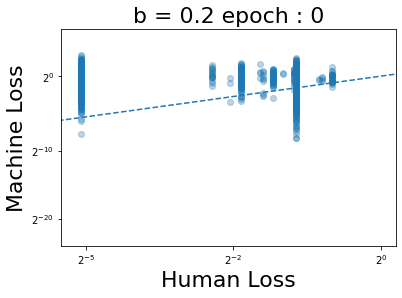

----- epoch: 1 -----
machine_loss: 0.7295844779970745
val_loss: 0.5787345170974731
updated the model


----- epoch: 2 -----
machine_loss: 0.2216008715428567
val_loss: 0.14093446731567383
updated the model


----- epoch: 3 -----
machine_loss: 0.1836978136198013
val_loss: 0.18290357291698456


----- epoch: 4 -----
machine_loss: 0.20565557413889715
val_loss: 0.12952066957950592
updated the model


----- epoch: 5 -----
machine_loss: 0.16881893815783164
val_loss: 0.3362191617488861




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


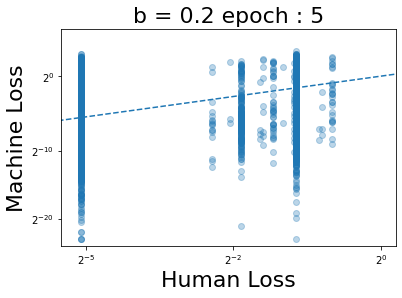

----- epoch: 6 -----
machine_loss: 0.2583421349263517
val_loss: 0.18900462985038757


----- epoch: 7 -----
machine_loss: 0.17043279053177685
val_loss: 0.17269845306873322


----- epoch: 8 -----
machine_loss: 0.18304447127593448
val_loss: 0.13676336407661438


----- epoch: 9 -----
machine_loss: 0.1624739092803793
val_loss: 0.12191978842020035
updated the model


----- epoch: 10 -----
machine_loss: 0.17394545460653413
val_loss: 0.2076910138130188




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


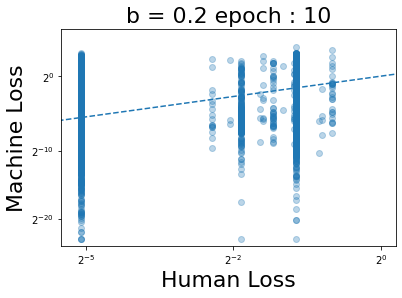

----- epoch: 11 -----
machine_loss: 0.19796766630800752
val_loss: 0.1649833470582962


----- epoch: 12 -----
machine_loss: 0.18654010309061655
val_loss: 0.14105914533138275


----- epoch: 13 -----
machine_loss: 0.16855713266219632
val_loss: 0.11282339692115784
updated the model


----- epoch: 14 -----
machine_loss: 0.16012758705498223
val_loss: 0.10165559500455856
updated the model


----- epoch: 15 -----
machine_loss: 0.16605466699062768
val_loss: 0.08687379211187363
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


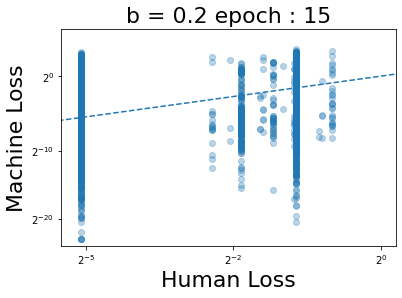

----- epoch: 16 -----
machine_loss: 0.15124854312186167
val_loss: 0.13632147014141083


----- epoch: 17 -----
machine_loss: 0.16239167064486537
val_loss: 0.16942758858203888


----- epoch: 18 -----
machine_loss: 0.19082493599853478
val_loss: 0.1273663192987442


----- epoch: 19 -----
machine_loss: 0.1443167975109342
val_loss: 0.09158781170845032


----- epoch: 20 -----
machine_loss: 0.151238545292775
val_loss: 0.08144097030162811
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


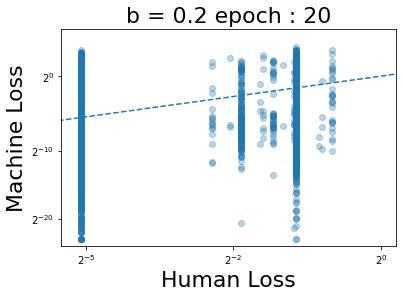

----- epoch: 21 -----
machine_loss: 0.156670316226761
val_loss: 0.17917503416538239


----- epoch: 22 -----
machine_loss: 0.18152819722308777
val_loss: 0.1403358429670334


----- epoch: 23 -----
machine_loss: 0.1723964277819808
val_loss: 0.10350832343101501


----- epoch: 24 -----
machine_loss: 0.15366973603280107
val_loss: 0.16157498955726624


----- epoch: 25 -----
machine_loss: 0.17301463866412328
val_loss: 0.12027569115161896




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


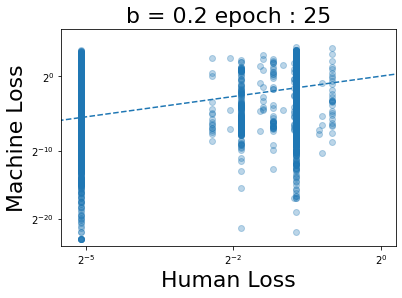

----- epoch: 26 -----
machine_loss: 0.16505953784508165
val_loss: 0.09348245710134506


----- epoch: 27 -----
machine_loss: 0.15418803865274336
val_loss: 0.24036045372486115


----- epoch: 28 -----
machine_loss: 0.19866520398257612
val_loss: 0.1343212127685547


----- epoch: 29 -----
machine_loss: 0.1522325209249781
val_loss: 0.07168075442314148
updated the model




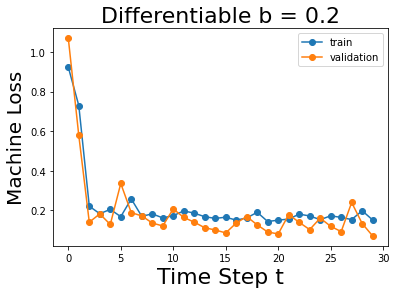

training machine model using constraint: 0.4  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.5330150756053627
val_loss: 0.46405738592147827
updated the model




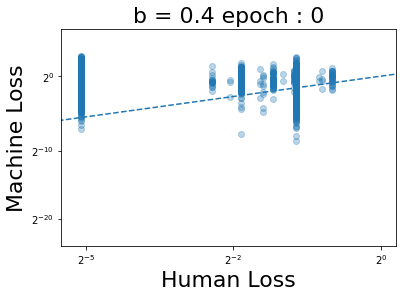

----- epoch: 1 -----
machine_loss: 0.02015476712646584
val_loss: 0.002516998676583171
updated the model


----- epoch: 2 -----
machine_loss: 0.0017462637518595632
val_loss: 0.0009809286566451192
updated the model


----- epoch: 3 -----
machine_loss: 0.0007833516028767917
val_loss: 0.0005668182275258005
updated the model


----- epoch: 4 -----
machine_loss: 0.0004870780703640776
val_loss: 0.00038877397309988737
updated the model


----- epoch: 5 -----
machine_loss: 0.0003440083203258837
val_loss: 0.00028380751609802246
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


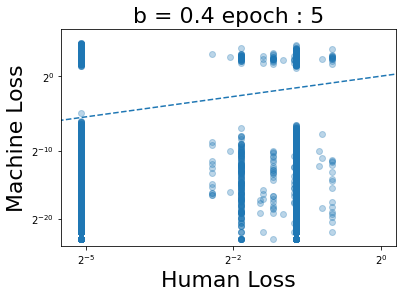

----- epoch: 6 -----
machine_loss: 0.00025036200289226446
val_loss: 0.0002188610378652811


----- epoch: 7 -----
machine_loss: 0.00019278468831392578
val_loss: 0.00017976640083361417
updated the model


----- epoch: 8 -----
machine_loss: 0.0001581127760725091
val_loss: 0.0001402608904754743


----- epoch: 9 -----
machine_loss: 0.0001304443437675218
val_loss: 0.00010603484406601638


----- epoch: 10 -----
machine_loss: 0.00010688290170908961
val_loss: 9.329237218480557e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


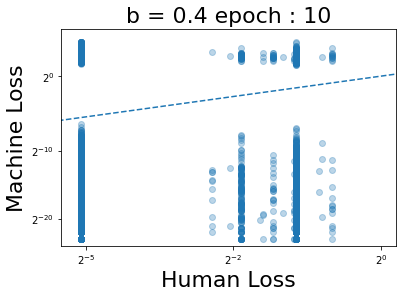

----- epoch: 11 -----
machine_loss: 8.953446790845494e-05
val_loss: 8.961422281572595e-05


----- epoch: 12 -----
machine_loss: 7.913115293926391e-05
val_loss: 6.65166589897126e-05
updated the model


----- epoch: 13 -----
machine_loss: 6.527305509962389e-05
val_loss: 5.9268626500852406e-05


----- epoch: 14 -----
machine_loss: 5.8248657666126746e-05
val_loss: 5.074301589047536e-05


----- epoch: 15 -----
machine_loss: 4.976340683053119e-05
val_loss: 4.622457709047012e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


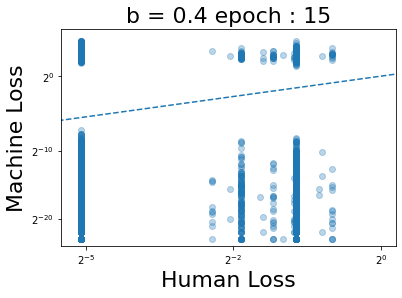

----- epoch: 16 -----
machine_loss: 4.63056580125946e-05
val_loss: 3.918296715710312e-05


----- epoch: 17 -----
machine_loss: 3.87674756391713e-05
val_loss: 3.4864839108195156e-05


----- epoch: 18 -----
machine_loss: 3.4707368428144036e-05
val_loss: 3.2158641261048615e-05


----- epoch: 19 -----
machine_loss: 3.0789200022714645e-05
val_loss: 2.87977272819262e-05


----- epoch: 20 -----
machine_loss: 2.694681451487213e-05
val_loss: 2.79447267530486e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


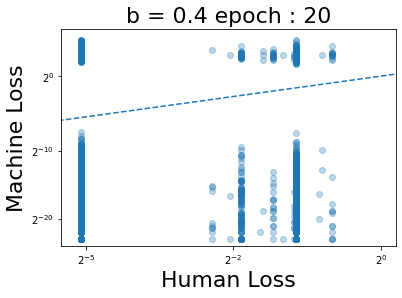

----- epoch: 21 -----
machine_loss: 2.4618257711495062e-05
val_loss: 2.0901359675917774e-05


----- epoch: 22 -----
machine_loss: 2.1757455949493003e-05
val_loss: 2.0372081053210422e-05


----- epoch: 23 -----
machine_loss: 2.0764500733368625e-05
val_loss: 1.757543759595137e-05
no progress for 10 epochs... stopping training


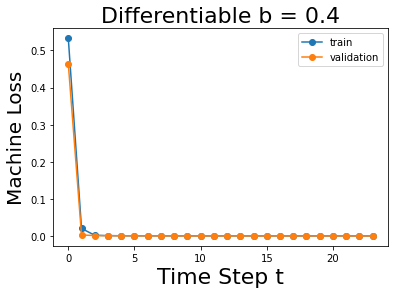

training machine model using constraint: 0.6  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.8661925854782263
val_loss: 0.7879749536514282
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


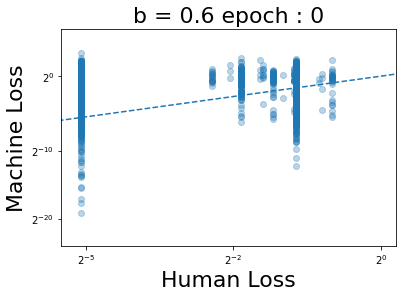

----- epoch: 1 -----
machine_loss: 0.3725192480099698
val_loss: 0.3703824579715729
updated the model


----- epoch: 2 -----
machine_loss: 0.049046414270075424
val_loss: 0.034147389233112335
updated the model


----- epoch: 3 -----
machine_loss: 0.004089188255420595
val_loss: 0.001160839106887579
updated the model


----- epoch: 4 -----
machine_loss: 0.0009059003982656577
val_loss: 0.0006194625748321414
updated the model


----- epoch: 5 -----
machine_loss: 0.0005120650043863861
val_loss: 0.0004194491484668106
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


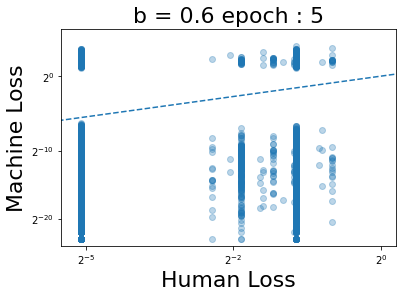

----- epoch: 6 -----
machine_loss: 0.00036227522923582
val_loss: 0.0002906951995100826
updated the model


----- epoch: 7 -----
machine_loss: 0.0002619314855868045
val_loss: 0.0002201972238253802


----- epoch: 8 -----
machine_loss: 0.00020562146570076342
val_loss: 0.00018203651416115463
updated the model


----- epoch: 9 -----
machine_loss: 0.00016745787949427418
val_loss: 0.00015131347754504532


----- epoch: 10 -----
machine_loss: 0.00013199772409204039
val_loss: 0.00013131166633684188




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


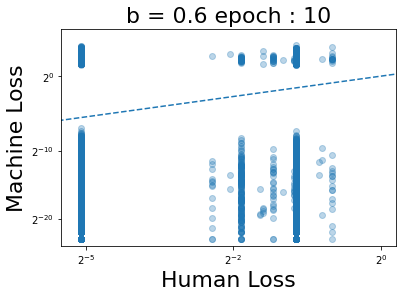

----- epoch: 11 -----
machine_loss: 0.00011170796733495081
val_loss: 0.00010631559416651726


----- epoch: 12 -----
machine_loss: 0.00010007687567773853
val_loss: 8.985634485725313e-05


----- epoch: 13 -----
machine_loss: 8.611751161424763e-05
val_loss: 7.806024950696155e-05
updated the model


----- epoch: 14 -----
machine_loss: 7.161535118408817e-05
val_loss: 6.609621050301939e-05


----- epoch: 15 -----
machine_loss: 6.473945735289514e-05
val_loss: 5.9304635215085e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


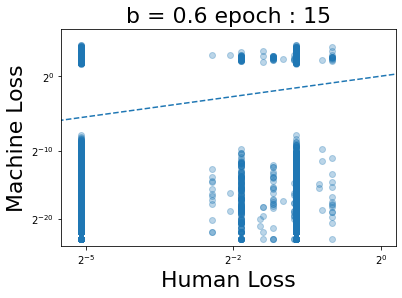

----- epoch: 16 -----
machine_loss: 5.5829330951458665e-05
val_loss: 5.1883071137126535e-05


----- epoch: 17 -----
machine_loss: 4.921164311137242e-05
val_loss: 4.7086428821785375e-05


----- epoch: 18 -----
machine_loss: 4.457864892041622e-05
val_loss: 4.2053266952279955e-05


----- epoch: 19 -----
machine_loss: 3.803363809140592e-05
val_loss: 3.56438358721789e-05


----- epoch: 20 -----
machine_loss: 3.447777145974366e-05
val_loss: 3.3211035770364106e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


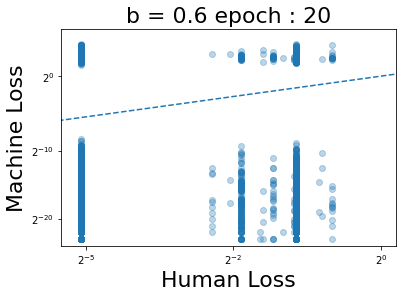

----- epoch: 21 -----
machine_loss: 3.158214797830775e-05
val_loss: 3.0115334084257483e-05


----- epoch: 22 -----
machine_loss: 2.7035101192988503e-05
val_loss: 2.5486548111075535e-05


----- epoch: 23 -----
machine_loss: 2.5237260845282588e-05
val_loss: 2.3457825591322035e-05


----- epoch: 24 -----
machine_loss: 2.1866721371092506e-05
val_loss: 1.894012893899344e-05
no progress for 10 epochs... stopping training


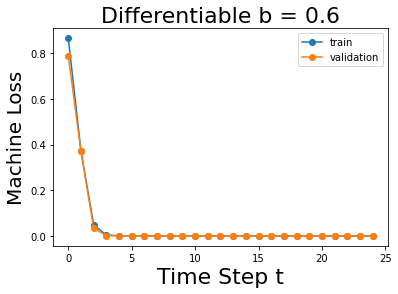

training machine model using constraint: 0.8  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.5241533967976769
val_loss: 0.4233383238315582
updated the model




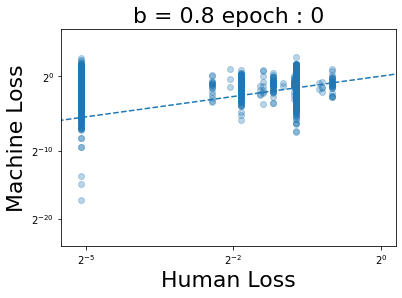

----- epoch: 1 -----
machine_loss: 0.02518846856006955
val_loss: 0.011202281340956688
updated the model


----- epoch: 2 -----
machine_loss: 0.0020177763796406603
val_loss: 0.0006867688498459756
updated the model


----- epoch: 3 -----
machine_loss: 0.0006757760207468285
val_loss: 0.00044416869059205055
updated the model


----- epoch: 4 -----
machine_loss: 0.0003670349430346202
val_loss: 0.0002709146065171808
updated the model


----- epoch: 5 -----
machine_loss: 0.0002462573371152151
val_loss: 0.00019880832405760884




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


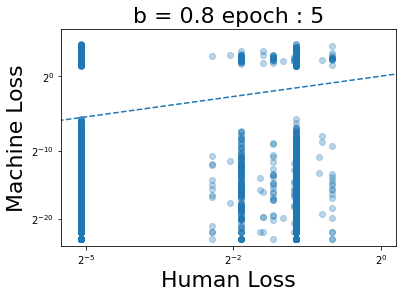

----- epoch: 6 -----
machine_loss: 0.0001731928532535676
val_loss: 0.0001471973373554647
updated the model


----- epoch: 7 -----
machine_loss: 0.00013176206905995969
val_loss: 0.00011542501306394115


----- epoch: 8 -----
machine_loss: 0.00010776886115119548
val_loss: 9.160530316876248e-05


----- epoch: 9 -----
machine_loss: 8.830328400695937e-05
val_loss: 7.420696783810854e-05


----- epoch: 10 -----
machine_loss: 7.179130061748158e-05
val_loss: 5.889279054827057e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


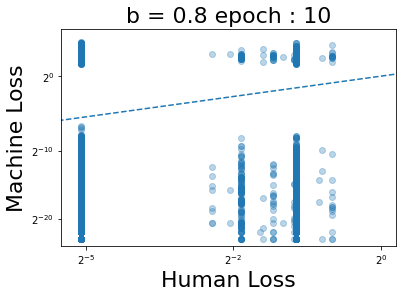

----- epoch: 11 -----
machine_loss: 5.9408357913071086e-05
val_loss: 5.514127769856714e-05


----- epoch: 12 -----
machine_loss: 5.1127440734433094e-05
val_loss: 4.4650689233094454e-05
updated the model


----- epoch: 13 -----
machine_loss: 4.3468508150586636e-05
val_loss: 3.9088019548216835e-05


----- epoch: 14 -----
machine_loss: 3.611570747115896e-05
val_loss: 3.427892079344019e-05


----- epoch: 15 -----
machine_loss: 3.3314178378892244e-05
val_loss: 2.9974380595376715e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


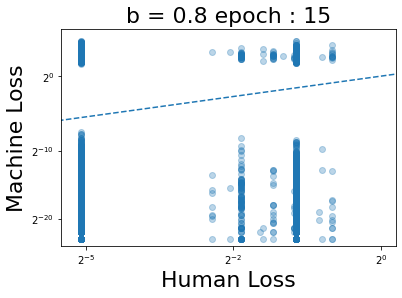

----- epoch: 16 -----
machine_loss: 2.9536045741925438e-05
val_loss: 2.6115823857253417e-05


----- epoch: 17 -----
machine_loss: 2.5728195675848536e-05
val_loss: 2.2890226318850182e-05


----- epoch: 18 -----
machine_loss: 2.2700903929380917e-05
val_loss: 2.101051723002456e-05


----- epoch: 19 -----
machine_loss: 2.1109066828728373e-05
val_loss: 1.7681004464975558e-05


----- epoch: 20 -----
machine_loss: 1.7789680081037318e-05
val_loss: 1.6301219147862867e-05




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log2


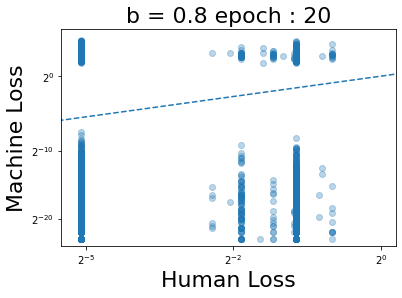

----- epoch: 21 -----
machine_loss: 1.6410728762868605e-05
val_loss: 1.3859551472705789e-05


----- epoch: 22 -----
machine_loss: 1.423817414488345e-05
val_loss: 1.1894836461578961e-05


----- epoch: 23 -----
machine_loss: 1.2391631320459359e-05
val_loss: 1.1105401426902972e-05
no progress for 10 epochs... stopping training


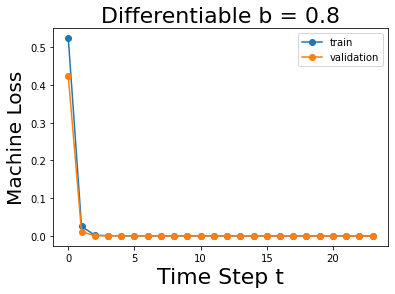

In [9]:
for constraint in constraints:
    train_triage(data_path,constraint)

#### We train the additional model g to approximate difference of machine loss and human loss for unseen samples. The same CNN and the same training procedure is used for training g. Please refer to 

In [36]:
def train_g(data_path, machine_type,constraint):
    print('started training g using the constraint: ',constraint,' Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(copy.deepcopy(data['X'])).float().to(device)
    Y = torch.from_numpy(copy.deepcopy(data['Y'])).long().to(device)
    hloss = data['hloss'].to(device)
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if machine_type == 'full':
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        
    else:
        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        
    mnet.eval()
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 50
    
    gnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
    
    g_optimizer = torch.optim.Adam(gnet.parameters())
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            g_loss = loss_func(gnet(X_batch),g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_machine_loss = loss_func(mnet(val_X),val_Y)
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X.shape[0])]).to(device)
            val_loss = loss_func(gnet(val_X),val_glabels)
            val_gloss = float(val_loss.mean())
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))
            
            if val_gloss + eps < best_val_loss:
                torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type + str(constraint))
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

                
        print('\n')
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g using b = ' + str(constraint),fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()
        

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.5642018932849169
val_g_loss: 0.5429787635803223
updated the model


----- epoch: 1 -----
g_loss: 0.5233003090446194
val_g_loss: 0.5235898494720459
updated the model


----- epoch: 2 -----
g_loss: 0.5035039723540345
val_g_loss: 0.5253085494041443


----- epoch: 3 -----
g_loss: 0.5087207169272006
val_g_loss: 0.5254386067390442


----- epoch: 4 -----
g_loss: 0.509070840353767
val_g_loss: 0.5166929364204407
updated the model


----- epoch: 5 -----
g_loss: 0.5029443399980664
val_g_loss: 0.5228891968727112


----- epoch: 6 -----
g_loss: 0.5044331822233895
val_g_loss: 0.5107583999633789
updated the model


----- epoch: 7 -----
g_loss: 0.4952967438536386
val_g_loss: 0.5104753375053406
updated the model


----- epoch: 8 -----
g_loss: 0.4943258635078867
val_g_loss: 0.5095419883728027
updated the model


----- epoch: 9 -----
g_loss: 0.49694805949305493
val_g_loss: 0.5087110996246338


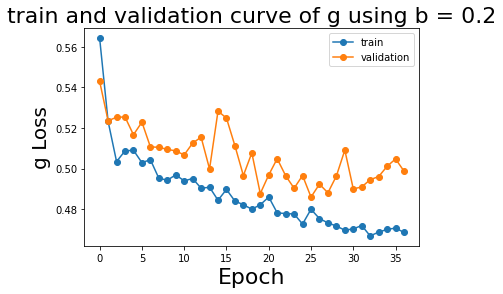

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6357245448355874
val_g_loss: 0.5468976497650146
updated the model


----- epoch: 1 -----
g_loss: 0.5551824481226504
val_g_loss: 0.5236405730247498
updated the model


----- epoch: 2 -----
g_loss: 0.5367073270802697
val_g_loss: 0.5282279253005981


----- epoch: 3 -----
g_loss: 0.5366957473258177
val_g_loss: 0.5075925588607788
updated the model


----- epoch: 4 -----
g_loss: 0.5308992903058728
val_g_loss: 0.5068556070327759
updated the model


----- epoch: 5 -----
g_loss: 0.5112728726429244
val_g_loss: 0.498951256275177
updated the model


----- epoch: 6 -----
g_loss: 0.5204778200325867
val_g_loss: 0.5058234333992004


----- epoch: 7 -----
g_loss: 0.5198501848305265
val_g_loss: 0.5001251697540283


----- epoch: 8 -----
g_loss: 0.5165569774496058
val_g_loss: 0.4977371096611023
updated the model


----- epoch: 9 -----
g_loss: 0.511121399855862
val_g_loss: 0.49197080731391907
u

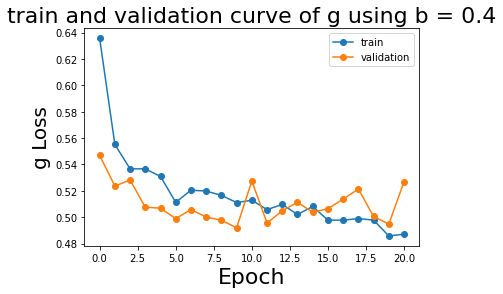

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6384994632874926
val_g_loss: 0.5590770244598389
updated the model


----- epoch: 1 -----
g_loss: 0.5601725550368428
val_g_loss: 0.5265143513679504
updated the model


----- epoch: 2 -----
g_loss: 0.5363613952261707
val_g_loss: 0.5191329121589661
updated the model


----- epoch: 3 -----
g_loss: 0.5338190391970178
val_g_loss: 0.5123217105865479
updated the model


----- epoch: 4 -----
g_loss: 0.5269126126853129
val_g_loss: 0.5033566355705261
updated the model


----- epoch: 5 -----
g_loss: 0.5274214389113089
val_g_loss: 0.49185848236083984
updated the model


----- epoch: 6 -----
g_loss: 0.5188140470224122
val_g_loss: 0.5073593258857727


----- epoch: 7 -----
g_loss: 0.526446502810965
val_g_loss: 0.49125590920448303
updated the model


----- epoch: 8 -----
g_loss: 0.5221044273736576
val_g_loss: 0.5023310780525208


----- epoch: 9 -----
g_loss: 0.526177532505244
val_g_loss: 0

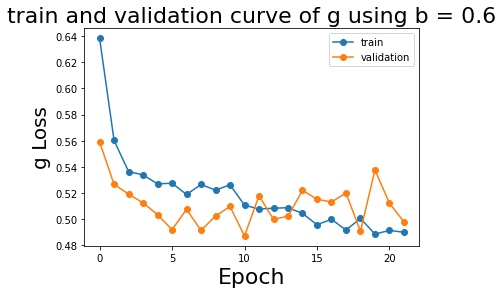

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6389615222190818
val_g_loss: 0.5538672804832458
updated the model


----- epoch: 1 -----
g_loss: 0.5603951262310147
val_g_loss: 0.5191187262535095
updated the model


----- epoch: 2 -----
g_loss: 0.5270871624040107
val_g_loss: 0.5394036769866943


----- epoch: 3 -----
g_loss: 0.539033392444253
val_g_loss: 0.5016143321990967
updated the model


----- epoch: 4 -----
g_loss: 0.5299071312571565
val_g_loss: 0.5168963670730591


----- epoch: 5 -----
g_loss: 0.5233405102044344
val_g_loss: 0.5179497003555298


----- epoch: 6 -----
g_loss: 0.5230368046710888
val_g_loss: 0.507673978805542


----- epoch: 7 -----
g_loss: 0.5127127757295966
val_g_loss: 0.49655672907829285
updated the model


----- epoch: 8 -----
g_loss: 0.5111354386123518
val_g_loss: 0.4949313998222351
updated the model


----- epoch: 9 -----
g_loss: 0.509518213259677
val_g_loss: 0.500056266784668


----- epoch: 10 ---

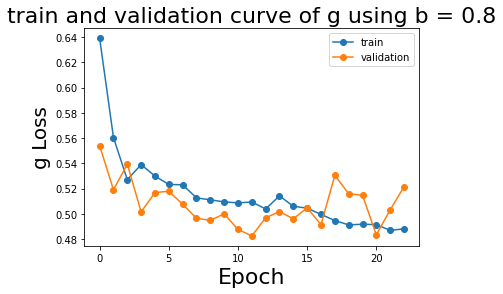

In [38]:
for constraint in constraints:
    train_g(data_path,'Differentiable',constraint)

In [12]:
def get_test_assignments_us(data_path,constraints):
    machine_type = 'Differentiable'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    losses = []
    for constraint in constraints:
        loss = np.zeros(test_X.shape[0])
        num_machine = int((1.0 - constraint) * test_X.shape[0])
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        mnet.eval()
        
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        
        gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)

        gnet.load_state_dict(torch.load(model_dir + 'g_Differentiable' + str(constraint)))
        gnet.eval()
        
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)
        
        loss[to_machine] = mloss[to_machine]
        loss[to_human] = hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        del gnet
    
    plt.plot(constraints,losses,marker='o')
    plt.xticks(constraints)
    plt.title(r'our method',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
    
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)

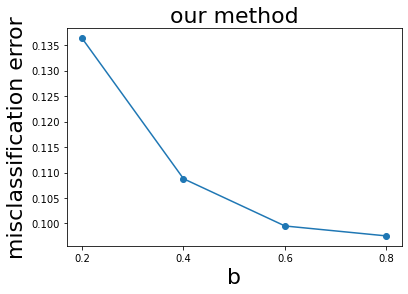

In [13]:
get_test_assignments_us(data_path,constraints)

# Baselines

## [Confidence Based Triage](https://arxiv.org/abs/2004.13102)

In [14]:
def train_confidence(data_path,constraint):
    machine_type = 'confidence'
    print('-----training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if constraint == 0.2:
        lr = 0.05
    if constraint == 0.4:
        lr = 0.0003
    else:
        lr = 0.0001
        
    optimizer = torch.optim.Adam(mnet.parameters(),lr = lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hconf_batch = hconf[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_conf_batch, _ = torch.max(machine_scores_batch,axis = 1)   
            machine_indices = find_machine_samples(hconf_batch,machine_conf_batch,constraint)
                
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_conf,_ = torch.max(val_machine_scores,axis=1)

            val_machine_indices = find_machine_samples(val_hconf,val_machine_conf,constraint)

            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            
            val_losses.append(val_loss)
            print('val_loss:',val_loss) 
            
            if val_loss + eps <best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
      
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model using constraint: 0.2  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8266059014325341
val_loss: 0.7668160796165466
updated the model


----- epoch: 1 -----
machine_loss: 0.7566208477752904
val_loss: 0.719716489315033
updated the model


----- epoch: 2 -----
machine_loss: 0.7144843423739076
val_loss: 0.7092192769050598
updated the model


----- epoch: 3 -----
machine_loss: 0.6881798769657811
val_loss: 0.6685277223587036
updated the model


----- epoch: 4 -----
machine_loss: 0.667331415694207
val_loss: 0.6538160443305969
updated the model


----- epoch: 5 -----
machine_loss: 0.6613781312480569
val_loss: 0.6584509611129761


----- epoch: 6 -----
machine_loss: 0.6475540228808919
val_loss: 0.6281402707099915
updated the model


----- epoch: 7 -----
machine_loss: 0.6463620108552277
val_loss: 0.622623860836029
updated the model


----- epoch: 8 -----
machine_loss: 0.6331059445316592
val_loss: 0.6028229594230652
updated the model


----- epoch:

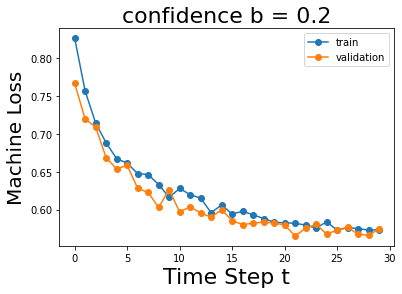

-----training machine model using constraint: 0.4  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8372411783784628
val_loss: 0.7435667514801025
updated the model


----- epoch: 1 -----
machine_loss: 0.7335431592849394
val_loss: 0.7112972140312195
updated the model


----- epoch: 2 -----
machine_loss: 0.6741142833294967
val_loss: 0.6627798080444336
updated the model


----- epoch: 3 -----
machine_loss: 0.6271895978910228
val_loss: 0.6039263606071472
updated the model


----- epoch: 4 -----
machine_loss: 0.6313495097371439
val_loss: 0.6143882274627686


----- epoch: 5 -----
machine_loss: 0.6084275923203677
val_loss: 0.6171875


----- epoch: 6 -----
machine_loss: 0.5853625849510232
val_loss: 0.6094942688941956


----- epoch: 7 -----
machine_loss: 0.6220439486205578
val_loss: 0.6159547567367554


----- epoch: 8 -----
machine_loss: 0.5685307721141726
val_loss: 0.5769935250282288
updated the model


----- epoch: 9 -----
machine_loss: 0.5903155708995959
val_loss: 0.576763

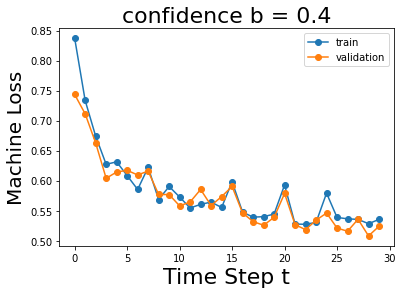

-----training machine model using constraint: 0.6  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8892377150865892
val_loss: 0.8868650794029236
updated the model


----- epoch: 1 -----
machine_loss: 0.8210097268844644
val_loss: 0.7409724593162537
updated the model


----- epoch: 2 -----
machine_loss: 0.7507880623452365
val_loss: 0.7781378626823425


----- epoch: 3 -----
machine_loss: 0.7156683147574464
val_loss: 0.7322971224784851
updated the model


----- epoch: 4 -----
machine_loss: 0.6905850111506879
val_loss: 0.7271077632904053
updated the model


----- epoch: 5 -----
machine_loss: 0.6904045711271465
val_loss: 0.6705947518348694
updated the model


----- epoch: 6 -----
machine_loss: 0.6457122747475902
val_loss: 0.6239405870437622
updated the model


----- epoch: 7 -----
machine_loss: 0.6317890175463011
val_loss: 0.6087849140167236
updated the model


----- epoch: 8 -----
machine_loss: 0.6404825620508442
val_loss: 0.6243141293525696


----- epoch: 9 -----
machin

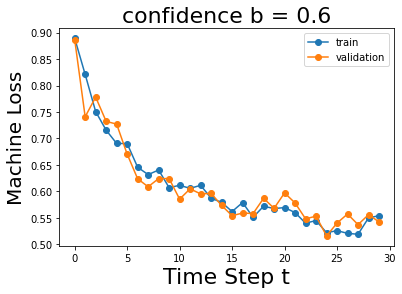

-----training machine model using constraint: 0.8  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9009213796816766
val_loss: 0.8639925122261047
updated the model


----- epoch: 1 -----
machine_loss: 0.8562366161495447
val_loss: 0.8758716583251953


----- epoch: 2 -----
machine_loss: 0.8183652531976501
val_loss: 0.7888616919517517
updated the model


----- epoch: 3 -----
machine_loss: 0.7710408798108498
val_loss: 0.7536927461624146
updated the model


----- epoch: 4 -----
machine_loss: 0.717964306861783
val_loss: 0.6919907331466675
updated the model


----- epoch: 5 -----
machine_loss: 0.6888969943393022
val_loss: 0.6946876645088196


----- epoch: 6 -----
machine_loss: 0.6823742859996855
val_loss: 0.6770287156105042
updated the model


----- epoch: 7 -----
machine_loss: 0.6717305233081182
val_loss: 0.6297199130058289
updated the model


----- epoch: 8 -----
machine_loss: 0.6735206122199694
val_loss: 0.6436269283294678


----- epoch: 9 -----
machine_loss: 0.637708500

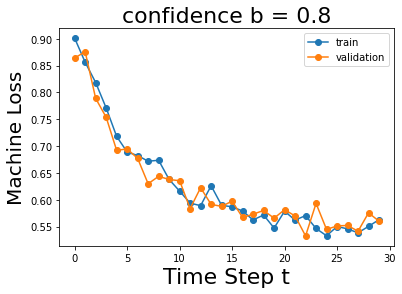

In [15]:
for constraint in constraints:
    train_confidence(data_path,constraint)

In [16]:
def get_test_assignments_confidence(data_path,constraints):
    machine_type = 'confidence'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    hconf = (torch.mean(data['hprob']) + torch.zeros(test_X.shape[0])).to(device)
    
    losses = []
    for constraint in constraints:
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_' + machine_type + str(constraint)))
        mnet.eval()
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        loss = np.zeros(test_X.shape[0])
        mconf,_ = torch.max(mnet(test_X),axis = 1)
        to_machine = find_machine_samples(hconf,mconf,constraint).cpu().data.numpy()

        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Confidence-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    
    save_data(data,data_path)

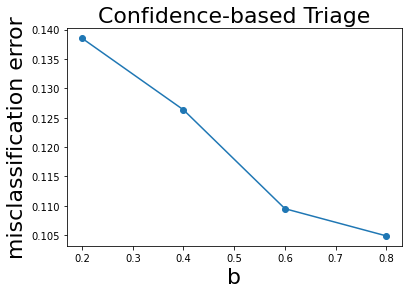

In [17]:
get_test_assignments_confidence(data_path,constraints)

## Full Automation Triage
The machine model is trained under full automation and then an additional model g is trained based on the difference of machine and human loss and used to outsource samples at test time.

In [18]:
def train_full(data_path, machine_type):
    print('-----training machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0]/batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.0002)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),Y_batch)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = float(loss_func(mnet(val_X),val_Y).mean())
            print('val_loss:',val_loss)
            val_losses.append(val_loss)
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type, fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model:  full
----- epoch: 0 -----
machine_loss: 0.8031298510419825
val_loss: 0.7341479063034058
updated the model


----- epoch: 1 -----
machine_loss: 0.719657179278632
val_loss: 0.6831042766571045
updated the model


----- epoch: 2 -----
machine_loss: 0.6891141581969956
val_loss: 0.6796451807022095
updated the model


----- epoch: 3 -----
machine_loss: 0.6811873416105906
val_loss: 0.6613176465034485
updated the model


----- epoch: 4 -----
machine_loss: 0.6637021532903115
val_loss: 0.6477273106575012
updated the model


----- epoch: 5 -----
machine_loss: 0.6591774777819713
val_loss: 0.6456629633903503
updated the model


----- epoch: 6 -----
machine_loss: 0.6430468014441431
val_loss: 0.6319553852081299
updated the model


----- epoch: 7 -----
machine_loss: 0.6482227820282181
val_loss: 0.6342100501060486


----- epoch: 8 -----
machine_loss: 0.6402236763387918
val_loss: 0.6364800930023193


----- epoch: 9 -----
machine_loss: 0.638100509531796
val_loss: 0.6227928996

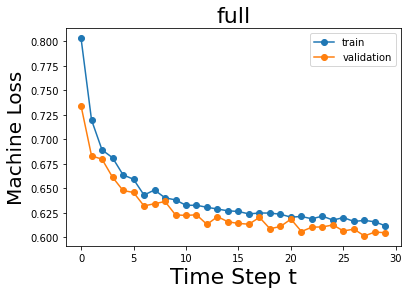

In [19]:
train_full(data_path,'full')

started training g using the constraint:  0.2  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.5536415283568203
val_g_loss: 0.5341169238090515
updated the model


----- epoch: 1 -----
g_loss: 0.5087268369582792
val_g_loss: 0.5231481790542603
updated the model


----- epoch: 2 -----
g_loss: 0.5106262356663743
val_g_loss: 0.5198906660079956
updated the model


----- epoch: 3 -----
g_loss: 0.5003786669112742
val_g_loss: 0.5163102746009827
updated the model


----- epoch: 4 -----
g_loss: 0.5067056847425798
val_g_loss: 0.5024629831314087
updated the model


----- epoch: 5 -----
g_loss: 0.49635564535856247
val_g_loss: 0.5066333413124084


----- epoch: 6 -----
g_loss: 0.494800621488442
val_g_loss: 0.5087810754776001


----- epoch: 7 -----
g_loss: 0.48968441349764663
val_g_loss: 0.514298141002655


----- epoch: 8 -----
g_loss: 0.4995111161842942
val_g_loss: 0.5039139986038208


----- epoch: 9 -----
g_loss: 0.49259349300215644
val_g_loss: 0.5011224746704102
updated the model


----- e

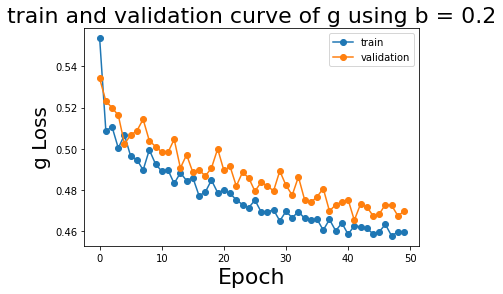

started training g using the constraint:  0.4  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.7003436175485452
val_g_loss: 0.6330718994140625
updated the model


----- epoch: 1 -----
g_loss: 0.6256238621038696
val_g_loss: 0.6531643271446228


----- epoch: 2 -----
g_loss: 0.6194603849823276
val_g_loss: 0.6826611757278442


----- epoch: 3 -----
g_loss: 0.6095420209070047
val_g_loss: 0.6055002808570862
updated the model


----- epoch: 4 -----
g_loss: 0.605359271944811
val_g_loss: 0.5925436019897461
updated the model


----- epoch: 5 -----
g_loss: 0.5988363983730475
val_g_loss: 0.6070749163627625


----- epoch: 6 -----
g_loss: 0.5890739474756023
val_g_loss: 0.6141787171363831


----- epoch: 7 -----
g_loss: 0.5942949798579017
val_g_loss: 0.5891417860984802
updated the model


----- epoch: 8 -----
g_loss: 0.5830617980100214
val_g_loss: 0.5929009914398193


----- epoch: 9 -----
g_loss: 0.5908221838374933
val_g_loss: 0.6032270789146423


----- epoch: 10 -----
g_loss: 0.5895495826068

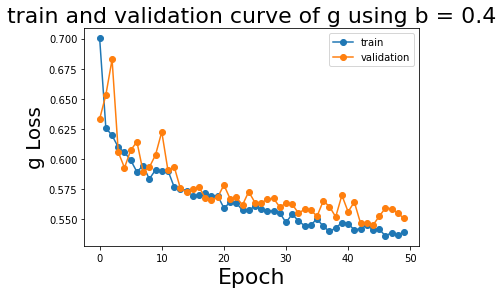

started training g using the constraint:  0.6  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.719623425665001
val_g_loss: 0.6521131992340088
updated the model


----- epoch: 1 -----
g_loss: 0.643695706812044
val_g_loss: 0.6474645137786865
updated the model


----- epoch: 2 -----
g_loss: 0.6394053262968858
val_g_loss: 0.624347984790802
updated the model


----- epoch: 3 -----
g_loss: 0.6227516035238901
val_g_loss: 0.646506667137146


----- epoch: 4 -----
g_loss: 0.6248439680784941
val_g_loss: 0.6159284710884094
updated the model


----- epoch: 5 -----
g_loss: 0.6213665863809487
val_g_loss: 0.6235724091529846


----- epoch: 6 -----
g_loss: 0.6148468346024553
val_g_loss: 0.6161808371543884


----- epoch: 7 -----
g_loss: 0.6146158894213537
val_g_loss: 0.6271948218345642


----- epoch: 8 -----
g_loss: 0.6096840961836278
val_g_loss: 0.6114718317985535
updated the model


----- epoch: 9 -----
g_loss: 0.6053514958669742
val_g_loss: 0.6186820268630981


----- epoch: 10 -----
g_loss: 

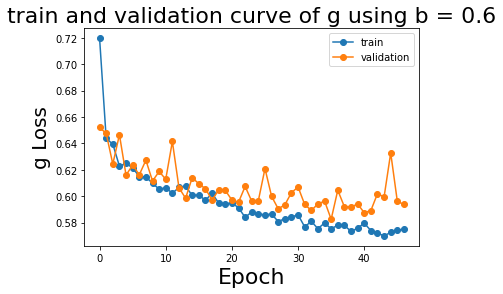

started training g using the constraint:  0.8  Using machine model:  full
----- epoch: 0 -----
g_loss: 0.6116239731200039
val_g_loss: 0.6025274395942688
updated the model


----- epoch: 1 -----
g_loss: 0.5640966738574207
val_g_loss: 0.5747244954109192
updated the model


----- epoch: 2 -----
g_loss: 0.5592502114983896
val_g_loss: 0.5684438347816467
updated the model


----- epoch: 3 -----
g_loss: 0.5547481797014674
val_g_loss: 0.5641924142837524
updated the model


----- epoch: 4 -----
g_loss: 0.5481595622065166
val_g_loss: 0.5386579036712646
updated the model


----- epoch: 5 -----
g_loss: 0.5458959736861289
val_g_loss: 0.5508192181587219


----- epoch: 6 -----
g_loss: 0.551821120393773
val_g_loss: 0.5516018271446228


----- epoch: 7 -----
g_loss: 0.5439257530185083
val_g_loss: 0.5504947900772095


----- epoch: 8 -----
g_loss: 0.5468172958741585
val_g_loss: 0.5407024621963501


----- epoch: 9 -----
g_loss: 0.5464982345389823
val_g_loss: 0.5468806624412537


----- epoch: 10 -----
g_los

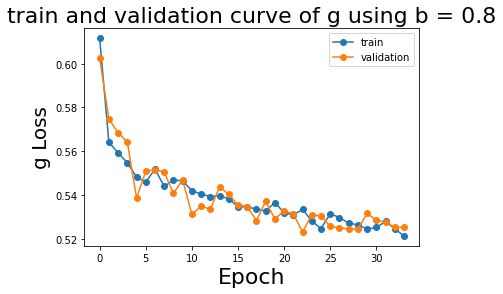

In [39]:
for constraint in constraints:
    train_g(data_path,'full',constraint)

In [23]:
def get_test_assignments_full(data_path,constraints):
    machine_type = 'full'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_full'))
    mnet.eval()
    mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
    
    losses = []
    for constraint in constraints:
        loss = np.zeros(test_X.shape[0])
        num_machine = int((1.0 - constraint) * test_X.shape[0])
    
        gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)

        gnet.load_state_dict(torch.load(model_dir + 'g_full' + str(constraint)))
        gnet.eval()
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Full Automaion Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data:
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)

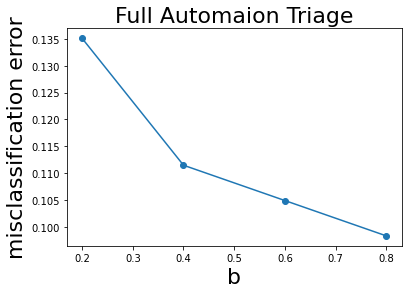

In [24]:
get_test_assignments_full(data_path,constraints)

## [Score-based Triage](https://arxiv.org/abs/1903.12220)

-----training machine model:  score
----- epoch: 0 -----
machine_loss: 0.7921872264705598
val_loss: 0.7329169511795044
updated the model


----- epoch: 1 -----
machine_loss: 0.7245577614133557
val_loss: 0.6945690512657166
updated the model


----- epoch: 2 -----
machine_loss: 0.695796167322745
val_loss: 0.6873226165771484
updated the model


----- epoch: 3 -----
machine_loss: 0.6822875590684513
val_loss: 0.6693167090415955
updated the model


----- epoch: 4 -----
machine_loss: 0.667284560855478
val_loss: 0.6484841704368591
updated the model


----- epoch: 5 -----
machine_loss: 0.663050445728004
val_loss: 0.6577134132385254


----- epoch: 6 -----
machine_loss: 0.6554876609394947
val_loss: 0.6465891003608704
updated the model


----- epoch: 7 -----
machine_loss: 0.648222331268092
val_loss: 0.6252819895744324
updated the model


----- epoch: 8 -----
machine_loss: 0.636813135817647
val_loss: 0.627250611782074


----- epoch: 9 -----
machine_loss: 0.64061923759679
val_loss: 0.627663433551788

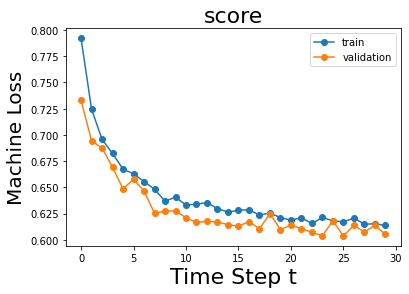

In [25]:
train_full(data_path,'score')

In [26]:
def get_assignments_score(data_path,constraints):
    machine_type = 'score'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_score'))
    mnet.eval()
    mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
    loss = np.zeros(test_X.shape[0])
    mconf,_ = torch.max(mnet(test_X),axis = 1)
    
    losses = []
    for constraint in constraints:
        num_machine = int((1.0-constraint) * test_X.shape[0])
        to_machine = torch.argsort(mconf,descending = True)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Score-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


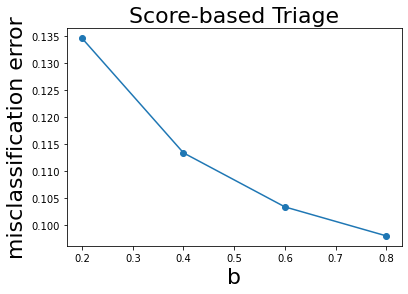

In [27]:
get_assignments_score(data_path,constraints)

## [Surrogate-based Triage](https://arxiv.org/abs/2006.01862)
The code is taken from [here](https://github.com/clinicalml/learn-to-defer) where the authors provide implementation of their method.

In [28]:
def surrogate_train(data_path):

    def loss_func(outputs, m, labels, m2, n_classes):
        '''
        The L_{CE} loss implementation for hatespeech, identical to CIFAR implementation
        ----
        outputs: network outputs
        m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        labels: target
        m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
        '''
        batch_size = outputs.shape[0] # batch_size
        rc = [n_classes] * batch_size

        rc = torch.tensor(rc)

        outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
        return torch.sum(outputs)/batch_size
    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate'
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)
    alpha = 1.0
    m = (1 - human_is_correct) * 1.0
    m2 = [1.0] * X.shape[0]
    m2 = torch.tensor(m2)
    for j in range(0, X.shape[0]):
        exp = m[j].item()
        if exp:
            m2[j] = alpha
        else:
            m2[j] = 1
    m2 = m2.to(device)


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (1 - val_human_is_correct) * 1.0
    val_m2 = [1.0] * val_X.shape[0]
    val_m2 = torch.tensor(val_m2)
    for j in range(0, val_X.shape[0]):
        exp = val_m[j].item()
        if exp:
            val_m2[j] = alpha
        else:
            val_m2[j] = 1
    val_m2 = val_m2.to(device)
    
    batch_size = 64
    num_epochs = 30

    num_batches = int(X.shape[0] / batch_size)
    
    N_FILTERS = 300  # hyperparameterr
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    output_dim = 3
    mnet = CNN_rej(embedding_dim = 100,vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.005)
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            m2_batch = m2[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),m_batch,Y_batch,m2_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        with torch.no_grad():
            m_val_prob = mnet(val_X)
            val_loss = loss_func(m_val_prob, val_m, val_Y, val_m2, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_surrogate')
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o', label = 'validation')
    plt.legend()
    plt.title(machine_type,fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.legend()
    plt.show()

-----training machine model : surrogate
----- epoch: 0 -----
train loss:  1.8128989568601053
validation loss:  1.5705726146697998
updated the model


----- epoch: 1 -----
train loss:  1.5600283754368622
validation loss:  1.4630004167556763
updated the model


----- epoch: 2 -----
train loss:  1.4657096207762759
validation loss:  1.3744335174560547
updated the model


----- epoch: 3 -----
train loss:  1.4090497080857556
validation loss:  1.3512040376663208
updated the model


----- epoch: 4 -----
train loss:  1.3828488274787862
validation loss:  1.3694531917572021


----- epoch: 5 -----
train loss:  1.357560155292352
validation loss:  1.3440417051315308
updated the model


----- epoch: 6 -----
train loss:  1.3592045006031792
validation loss:  1.3607248067855835


----- epoch: 7 -----
train loss:  1.3588966624811292
validation loss:  1.3679505586624146


----- epoch: 8 -----
train loss:  1.3620960585152109
validation loss:  1.3571423292160034


----- epoch: 9 -----
train loss:  1.3628151

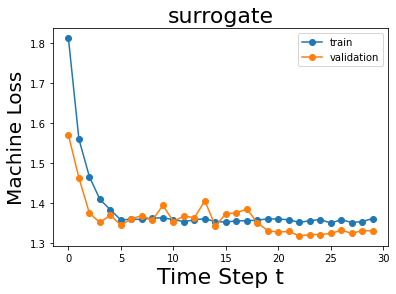

In [29]:
surrogate_train(data_path)

In [30]:
def get_test_assignments_surrogate(data_path,constraints):
    machine_type = 'surrogate'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN_rej(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_surrogate'))
    mnet.eval()
    mscores = mnet(test_X)
    assert(mscores.shape[1]==4)
    mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
    assert (mlabel<4).all()
    loss = np.zeros(test_X.shape[0])
    last_class_prob = mscores[:,-1]
    highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
    diff = last_class_prob - highest_prob
    
    losses = []
    for constraint in constraints:
        num_machine = int((1.0-constraint) * test_X.shape[0])
        to_machine = torch.argsort(diff)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Surrogate-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    
    if machine_type not in data.keys():
        data[machine_type] = {}

    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


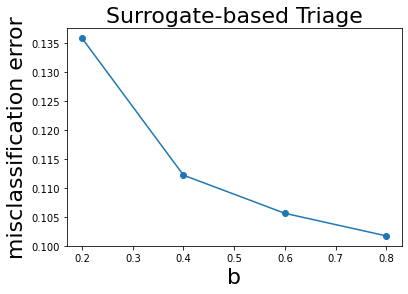

In [31]:
get_test_assignments_surrogate(data_path,constraints)

In [32]:
def plot_misclassification_loss(data_path,machine_types):
    data = load_data(data_path)
    print(data.keys())
    for machine_type in machine_types:
        agg_loss = data[machine_type]['agg_loss']
        plt.plot(constraints,agg_loss,marker='o',label=machine_type)
    plt.xticks(constraints)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.legend()

dict_keys(['X', 'Y', 'c', 'hpred', 'val', 'test', 'dist_mat', 'hloss', 'hprob', 'Differentiable', 'confidence', 'full', 'score', 'surrogate'])


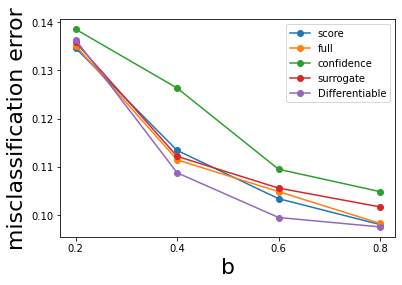

In [33]:
machine_types =  ['score','full','confidence','surrogate','Differentiable']
plot_misclassification_loss(data_path,machine_types)